## 1. VHM Dataset

In [152]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [153]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('1-VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)

In [154]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [155]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [156]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [157]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [158]:
# 7. Define MLP Model

model=Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [159]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 3s 23ms/step - loss: 0.1083 - val_loss: 0.0429
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0297 - val_loss: 0.0077
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0062
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0042
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 8/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 10/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 1

In [160]:
# 9. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 35ms/step


In [161]:
# 10. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [162]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, explained_variance_score

# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

r2_valid = r2_score(yval, y_pred_val)
r2_test = r2_score(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

print('Validation R^2 score:', r2_valid)
print('Testing R^2 score:', r2_test)


Validation RMSE: 42324.67999942887
Testing RMSE: 60408.708598770645
Validation MAPE: 527440.580918486
Testing MAPE: 145559.2794197101
Validation MAE: 42310.99727432766
Testing MAE: 60373.520756770675
Validation R^2 score: -2242820820186.684
Testing R^2 score: -1099889971122.5442


In [163]:
# 12. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

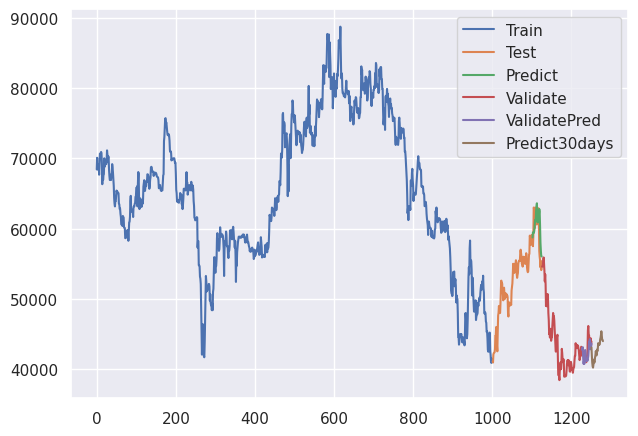

In [164]:
# 13.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 2. NVL Dataset

In [165]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [166]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('2-NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)

In [167]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [168]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [169]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [170]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [171]:
# 7. Define MLP Model

model=Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [172]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 15ms/step - loss: 0.0246 - val_loss: 0.0537
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0408
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0364
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0350
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0350
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0397
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0422
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0410
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0417
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0405
Epoch 11

In [173]:
# 9. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 23ms/step


In [174]:
# 10. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [175]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, explained_variance_score

# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

r2_valid = r2_score(yval, y_pred_val)
r2_test = r2_score(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

print('Validation R^2 score:', r2_valid)
print('Testing R^2 score:', r2_test)


Validation RMSE: 17425.591197990758
Testing RMSE: 27097.681230912942
Validation MAPE: 212793.44956528093
Testing MAPE: 1.2143849425281777e+18
Validation MAE: 17421.20596786482
Testing MAE: 23953.777171348698
Validation R^2 score: -14604362325055.701
Testing R^2 score: -751431632353.9601


In [176]:
# 12. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

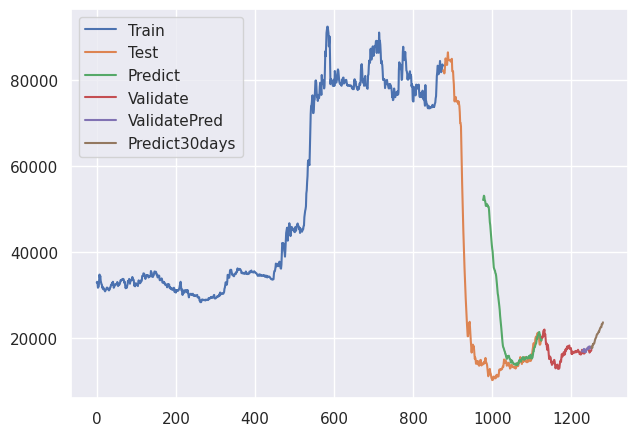

In [177]:
# 13.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 3. NLG Dataset

In [178]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [179]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('3-NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df1 = df_reversed['Price']
# Remove commas and convert to float
df1 = df1.str.replace(',', '').astype(float)

In [180]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [181]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [182]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [183]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [184]:
# 7. Define MLP Model

model=Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [185]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 24ms/step - loss: 0.0536 - val_loss: 0.0168
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.0049
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 9/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 11

In [186]:
# 9. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 21ms/step


In [187]:
# 10. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [188]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, explained_variance_score

# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

r2_valid = r2_score(yval, y_pred_val)
r2_test = r2_score(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

print('Validation R^2 score:', r2_valid)
print('Testing R^2 score:', r2_test)


Validation RMSE: 39984.02946997617
Testing RMSE: 31898.86852411892
Validation MAPE: 80414.4891585881
Testing MAPE: 94463.87523104822
Validation MAE: 39970.68362157785
Testing MAE: 31579.34009955296
Validation R^2 score: -10699429261702.742
Testing R^2 score: -123306693999.24207


In [189]:
# 12. Dự báo 30 ngày tiếp theo
x_input = val_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i < 30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])  # Ensure the input is the last 100 steps
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]  # Keep size consistent by removing the oldest element
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

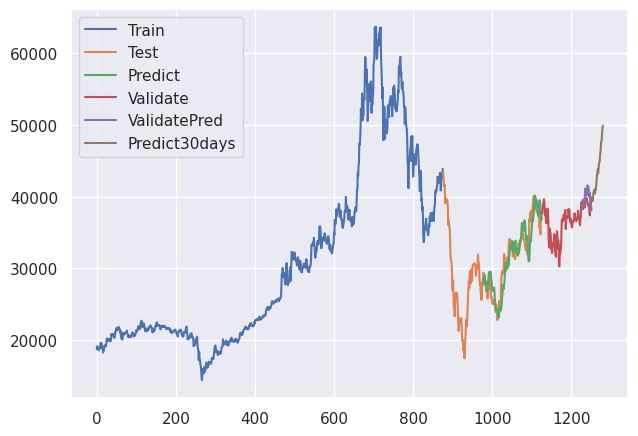

In [190]:
# 13.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()